In [1]:
# MNIST experiment in NGSpice and Nengo

In [2]:
!pip install nengo
!pip install numpy
!pip install sklearn
!pip install  matplotlib
!pip install pyspice
!sudo add-apt-repository ppa:kicad/kicad-5.1-releases -y
!sudo apt-get update
!sudo apt-get install libngspice-kicad

     |████████████████████████████████| 532kB 14.5MB/s 
     |████████████████████████████████| 153kB 13.4MB/s 
     |████████████████████████████████| 276kB 17.9MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=8392c2619994b52ed1d4bf797a3274b7b4d6c157a816ceecf49b5c12f95ca42e
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built PyYAML
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRele

In [3]:
# Load the library file

from google.colab import files
uploaded =  files.upload() #upload the 180nm.lib file here

Saving 180nm.lib to 180nm.lib


In [4]:
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()
from PySpice.Spice.NgSpice.Shared import NgSpiceShared
ngspice = NgSpiceShared.new_instance()
print(ngspice.exec_command('version -f'))

2021-01-04 20:57:41,759 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - spinit was not found
2021-01-04 20:57:41,761 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - ERROR - Note: can't find init file.
******
** ngspice-30 : Circuit level simulation program
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Please get your ngspice manual from http://ngspice.sourceforge.net/docs.html
** Please file your bug-reports at http://ngspice.sourceforge.net/bugrep.html
** Creation Date: Wed Feb 27 13:04:52 UTC 2019
**
** CIDER 1.b1 (CODECS simulator) included
** XSPICE extensions included
** Relevant compilation options (refer to user's manual):
** OpenMP multithreading for BSIM3, BSIM4 enabled
** X11 interface not compiled into ngspice
**
******


In [5]:
import nengo
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
#fetch data
mnist = sklearn.datasets.fetch_openml('mnist_784')

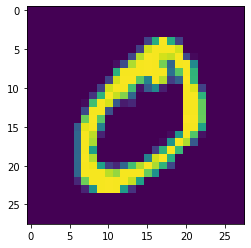

In [75]:
## view data
sample = 1
image = mnist['data'][sample]
image = image.reshape(28,28)
# plot the sample
fig = plt.figure
plt.imshow(image)
plt.show()


In [76]:
## data preprocessing
x = mnist['data'].astype(float)-128
x = x/np.linalg.norm(x, axis=1)[:,None]
       
y = mnist['target']
y = np.eye(10)[y.astype(int)]*2-1
y = y/np.linalg.norm(y, axis=1)[:,None]

order = np.arange(len(x))
np.random.shuffle(order)
x = x[order]
y = y[order]

In [77]:
#parameters

n_training=10
n_testing=5

n_neurons=50
synapse=0.02
t_image=0.5
dt = 0.001

In [78]:
neuron_model = '''
.subckt my_neuron Vmem out cvar=100p vsupply=1.8 vtau=0.4 vthr=0.2 vb=1

V1 Vdd 0 {vsupply}
V6 Vtau 0 {vtau}
V2 Vthr 0 {vthr}
V3 Vb1 0 {vb}
C1 Vmem 0 {cvar}


M5 N001 N001 Vdd Vdd pmos l=0.5 w=1.2 ad=1.2 as=1.2 pd=4.4 ps=4.4
M6 N002 N001 Vdd Vdd pmos l=0.5 w=1.2 ad=1.2 as=1.2 pd=4.4 ps=4.4
M8 N001 Vmem N004 N004 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
M9 N002 Vthr N004 N004 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
M10 N004 Vb1 0 0 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
Mreset Vmem out 0 0 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
M7 N003 N002 0 0 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
M18 out N003 0 0 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2
M19 N003 N002 Vdd Vdd pmos l=0.5 w=1.2 ad=1.2 as=1.2 pd=4.4 ps=4.4
M20 out N003 Vdd Vdd pmos l=0.5 w=1.2 ad=1.2 as=1.2 pd=4.4 ps=4.4
Mleak Vmem Vtau 0 0 nmos l=0.5 w=0.6 ad=0.6 as=0.6 pd=3.2 ps=3.2


.ends my_neuron
'''

In [79]:
def create_neuron_netlist(N):
    # N is the number of neurons
    netlist = ''
    for i in range(N):
        netlist += 'x'+str(i)+' Vmem'+str(i)+' out'+str(i)+' my_neuron vsupply={vsource} cvar=150p vthr=0.25 \n'
        netlist += 'Rload'+str(i)+' out'+str(i)+ ' 0 100k\n'
    return netlist

In [80]:
def pwl_conv(signal):
    # signal should be a list of lists where wach sublist has this form [time_value, current_value]
    pwl_string = ''
    for i in signal:
        pwl_string += str(i[0]) + ' ' + str(i[1]) + ' '
    return pwl_string

In [81]:
def stim_func(t, data=x[:n_training]):
    index = int(t / t_image)
    return data[index % len(data)]

In [82]:
time = dt*np.linspace(0, int(t_image*n_training/dt), int(t_image*n_training/dt))

In [83]:
stim  = [stim_func(t) for t in time]

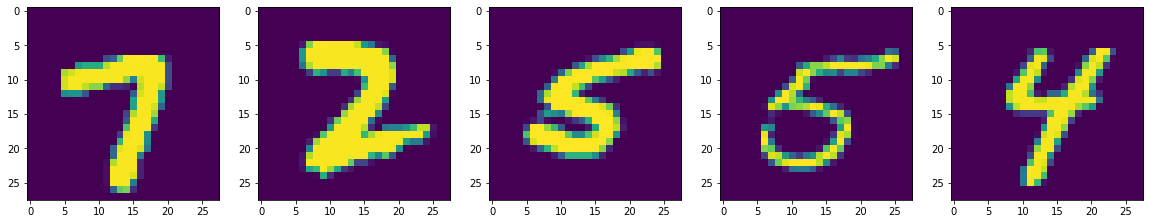

In [84]:
plt.figure(figsize=(20,10))
columns = 5
plt.subplot(151)
plt.imshow(stim[1].reshape(28,28))
plt.subplot(152)
plt.imshow(stim[501].reshape(28,28))
plt.subplot(153)
plt.imshow(stim[1001].reshape(28,28))
plt.subplot(154)
plt.imshow(stim[1501].reshape(28,28))
plt.subplot(155)
plt.imshow(stim[2001].reshape(28,28))

In [85]:
def target_func(t, data=y[:n_training]):
    index = int(t / t_image)
    c = np.argmax(data[index% len(data)])
    return c

In [86]:
target  = [target_func(t) for t in time]
#plt.plot(target)

In [87]:
N = n_neurons  # how many neurons there are
dimensions = 784
E = np.random.normal(size=(N, dimensions))
B = np.random.normal(size=(N))*0.1

netlist_neurons = create_neuron_netlist(N)

In [88]:
def pwl_conv(signal):
    # signal should be a list of lists where wach sublist has this form [time_value, current_value]
    pwl_string = ''
    for i in signal:
        pwl_string += str(i[0]) + ' ' + str(i[1]) + ' '
    return pwl_string

def create_neuron_current_netlist(E,B,stim,N):
    # take the A matrix and the number of neurons
    # refactor 
    netlist_input='\n'
    signal = np.zeros((len(stim), N))
    for i, J in enumerate(stim):
        Js = np.dot(E, J)
        for k, JJ in enumerate(Js):
            signal[i][k] = JJ+B[k]
    
    for k in range(N):
        input_signal = [[i*1e-6, J*10e-6] for i, J in enumerate(signal[:,k])]
        netlist_input += 'Iin'+str(k)+' Vdd Vmem'+str(k)+' PWL(' + pwl_conv(input_signal) +')\n\n'
    
    return netlist_input
    

In [89]:
## other setup parameters
args= {}
args['simulation_time'] = '1m'
args['simulation_step'] = '1u'
args['simulation_lib']  = '180nm.lib'


netlist_top= '''*Sample SPICE file
.include {simulation_lib}
.option scale=1u
.OPTIONS ABSTOL=1N VNTOL=1M.
.options savecurrents
.tran {simulation_step} {simulation_time} UIC
'''.format(**args)

netlist_bottom = '''
.end'''

In [90]:
## define the sources
netlist_source = '''
.param vsource = 1.8
Vdd Vdd 0 {vsource}
'''

In [91]:
netlist_inputs = create_neuron_current_netlist(E,B,stim,N)

In [92]:
def simulate(circuit):
    ngspice.load_circuit(circuit)
    ngspice.run()
    print('Plots:', ngspice.plot_names)
    plot = ngspice.plot(simulation=None, plot_name=ngspice.last_plot)
    return plot

In [93]:
netlist = netlist_top + netlist_source + neuron_model + netlist_inputs+ netlist_neurons+ netlist_bottom
out=simulate(netlist)

2021-01-04 21:05:08,296 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin49: no DC value, transient time 0 value used
2021-01-04 21:05:08,297 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin48: no DC value, transient time 0 value used
2021-01-04 21:05:08,298 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin47: no DC value, transient time 0 value used
2021-01-04 21:05:08,298 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin46: no DC value, transient time 0 value used
2021-01-04 21:05:08,299 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin45: no DC value, transient time 0 value used
2021-01-04 21:05:08,300 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin44: no DC value, transient time 0 value used
2021-01-04 21:05:08,301 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin43

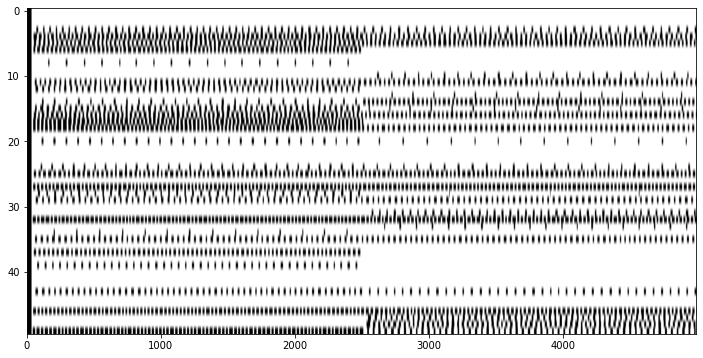

In [94]:
def extract_A_matrix(result, N, stim):
    t = np.linspace(min(out['time']._data), max(out['time']._data), len(stim))
    temp_time = out['time']._data
    inpterpolated_result = np.zeros((len(stim), N))
    A = np.zeros((len(stim), N))
    for j in range(N):
        temp_str = '@rload'+str(j)+'[i]'
        temp_out = result[temp_str]._data
        inpterpolated_result[:,j] = np.interp(t, temp_time, temp_out)
        A[:,j] = inpterpolated_result[:,j] > max(inpterpolated_result[:,j])/2
    return A
A_from_spice = extract_A_matrix(out, N, stim)
plt.figure(figsize=(12,6))
plt.imshow(A_from_spice.T, aspect='auto', cmap='gray_r')
plt.show()

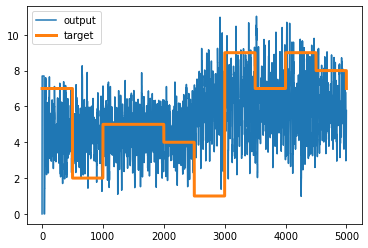

In [95]:
D, info = nengo.solvers.LstsqL2()(A_from_spice, target)

plt.plot(A_from_spice.dot(D), label='output')
plt.plot(target, lw=3, label='target')
plt.legend()
plt.show()

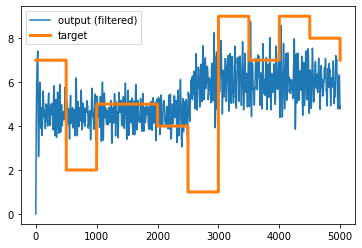

In [96]:
filt = nengo.synapses.Lowpass(0.01) #need to implement synapses in circuit
plt.plot(filt.filt(A_from_spice.dot(D)), label='output (filtered)')
plt.plot(target, lw=3, label='target')
plt.legend()
plt.show()

In [97]:
#testing

In [98]:
def test_x_func(t, data=x[n_training:]):
    index = int(t / t_image)
    return data[index % len(data)]

In [99]:
time = dt*np.linspace(0, int(t_image*n_testing/dt), int(t_image*n_testing/dt))

In [100]:
test_input  = [test_x_func(t) for t in time]

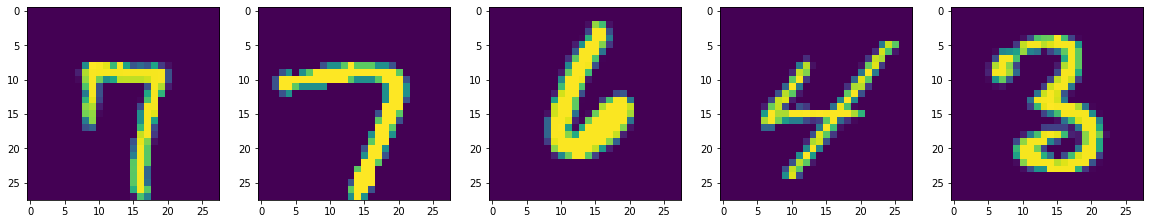

In [101]:
plt.figure(figsize=(20,10))
columns = 5
plt.subplot(151)
plt.imshow(test_input[1].reshape(28,28))
plt.subplot(152)
plt.imshow(test_input[501].reshape(28,28))
plt.subplot(153)
plt.imshow(test_input[1001].reshape(28,28))
plt.subplot(154)
plt.imshow(test_input[1501].reshape(28,28))
plt.subplot(155)
plt.imshow(test_input[2001].reshape(28,28))

In [102]:
def test_y_func(t, data=y[n_training:]):
    index = int(t / t_image)
    c = np.argmax(data[index% len(data)])
    return c

In [103]:
target  = [test_y_func(t) for t in time]

In [104]:
netlist_inputs = create_neuron_current_netlist(E,B,test_input,N)
netlist = netlist_top + netlist_source + neuron_model + netlist_inputs+ netlist_neurons+ netlist_bottom
out=simulate(netlist)

2021-01-04 21:05:55,551 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin49: no DC value, transient time 0 value used
2021-01-04 21:05:55,552 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin48: no DC value, transient time 0 value used
2021-01-04 21:05:55,552 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin47: no DC value, transient time 0 value used
2021-01-04 21:05:55,553 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin46: no DC value, transient time 0 value used
2021-01-04 21:05:55,554 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin45: no DC value, transient time 0 value used
2021-01-04 21:05:55,556 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin44: no DC value, transient time 0 value used
2021-01-04 21:05:55,557 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - Warning: iin43

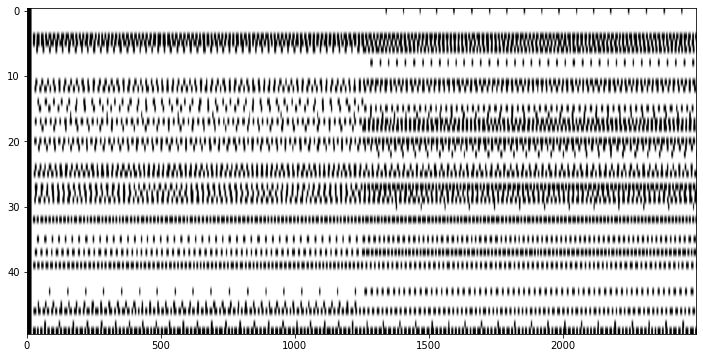

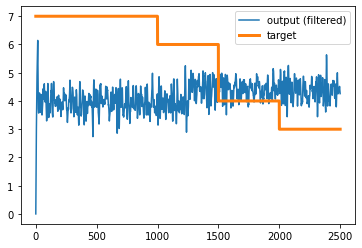

In [105]:
A_test = extract_A_matrix(out, N, test_input)
plt.figure(figsize=(12,6))
plt.imshow(A_test.T, aspect='auto', cmap='gray_r')
plt.show()
filt = nengo.synapses.Lowpass(0.01) #need to implement synapses in circuit
plt.plot(filt.filt(A_test.dot(D)), label='output (filtered)')
plt.plot(target, lw=3, label='target')
plt.legend()
plt.show()

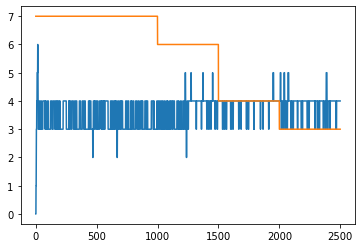

In [106]:
#plt.figure(figsize=(12,6))
plt.plot(np.floor(filt.filt(A_test.dot(D))), label='output (filtered)')
plt.plot(target)

In [107]:
output = filt.filt(A_test.dot(D))
confusion = np.zeros((10,10), dtype=int)
count = np.zeros(10, dtype=int)
for i in range(n_testing):
  t = (i + 1) * t_image
  index = np.argmax(time >= t) - 1
  count[target[index]] += 1
  confusion[target[index],int(output[index])] += 1
score = sum(confusion[i, i] for i in range(10)) / float(n_testing)
print(score)

0.2
